# EDA Análisis exploratorio de datos

## Importando librerías

In [1]:
import re
import sketch
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geojson
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary

### Ingesta de datos desde el dataset limpio `siniestros_limpio`

In [2]:
siniestrosLimpio= pd.read_csv("siniestosLimpio.csv")
siniestrosLimpio.head(3)

,Id,Fecha,Año,Mes,Día,Día semana,Hora completa,Hora,Num víctimas,Participantes,...,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,Xy (caba),Coordenada x,Coordenada y,Pos x,Pos y
0,2016-0001,2016-01-01,2016,1,1,Viernes,04:00:00,4.0,1,MOTO-AUTO,...,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",Comuna Comuna 8,Point (98896.78238426 93532.43437792),98896.782384,93532.434378,-58.475340,-34.687570
1,2016-0002,2016-01-02,2016,1,2,Sabado,01:15:00,1.0,1,AUTO-PASAJEROS,...,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",Comuna Comuna 9,Point (95832.05571093 95505.41641999),95832.055711,95505.416420,-58.508775,-34.669777
2,2016-0003,2016-01-03,2016,1,3,Domingo,07:00:00,7.0,1,MOTO-AUTO,...,AVENIDA,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,Comuna Comuna 1,Point (106684.29090040 99706.57687843),106684.290900,99706.576878,-58.390403,-34.631894


In [3]:
siniestrosLimpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     717 non-null    object 
 1   Fecha                  717 non-null    object 
 2   Año                    717 non-null    int64  
 3   Mes                    717 non-null    int64  
 4   Día                    717 non-null    int64  
 5   Día semana             717 non-null    object 
 6   Hora completa          717 non-null    object 
 7   Hora                   716 non-null    float64
 8   Num víctimas           717 non-null    int64  
 9   Participantes          717 non-null    object 
 10  Rol                    717 non-null    object 
 11  Acusado                717 non-null    object 
 12  Victima                717 non-null    object 
 13  Sexo                   717 non-null    object 
 14  Edad                   717 non-null    int64  
 15  Rango 

## Outliers

Se realiza la busqueda de datos con valores atípicos en las features, y se analiza si es necesario eliminarlos.  

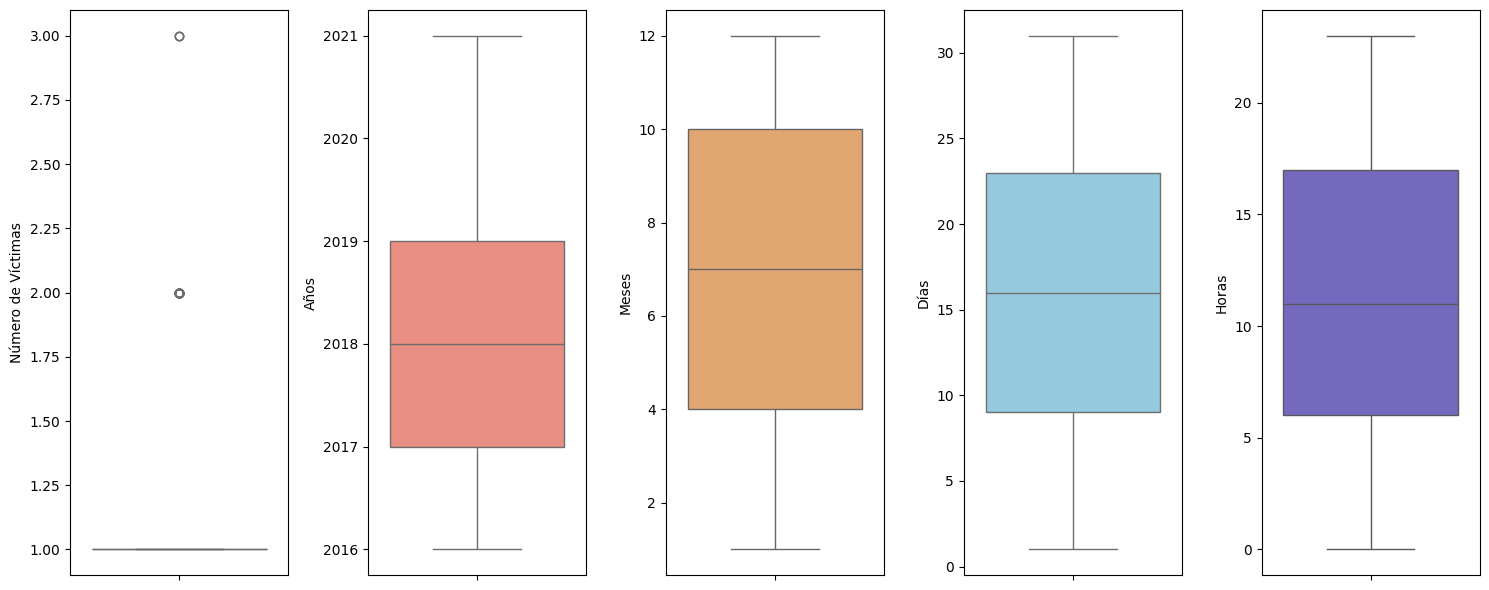

In [4]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(15, 6))

# Crear subplots para los gráficos 
plt.subplot(1, 5, 1) 
sns.boxplot(data=siniestrosLimpio, y='Num víctimas', color = "#FA8072")
plt.ylabel('Número de Víctimas')

plt.subplot(1, 5, 2) 
sns.boxplot(data=siniestrosLimpio, y='Año', color = "#FA8072")
plt.ylabel('Años')

plt.subplot(1, 5, 3) 
sns.boxplot(data=siniestrosLimpio, y='Mes', color = "#F4A460")
plt.ylabel('Meses')

plt.subplot(1, 5, 4) 
sns.boxplot(data=siniestrosLimpio, y='Día', color = "#87CEEB")
plt.ylabel('Días')

plt.subplot(1, 5, 5) 
sns.boxplot(data=siniestrosLimpio, y='Hora', color = "#6A5ACD")
plt.ylabel('Horas')

# Ajustar espaciado entre subplots
plt.tight_layout()

plt.show()

#### **Conclusión**
- Es posible detectar que los Outliers se ubican en feature `Num víctimas` (valores 2 ó 3), esto se le atribuye al hecho de que en la gran mayoria de los casos el valor de `Num víctimas` es igual a 1. 

### Variables Númericas

El conjunto de datos contiene variables numéricas o que incluyen números. Sin embargo, su uso como tales dependerá del contexto de los datos.

En este caso, se utiliza un mapa de correlaciones para examinar si existen relaciones entre las variables numéricas. Además, se analizarán algunas variables como categóricas para realizar un análisis correcto.


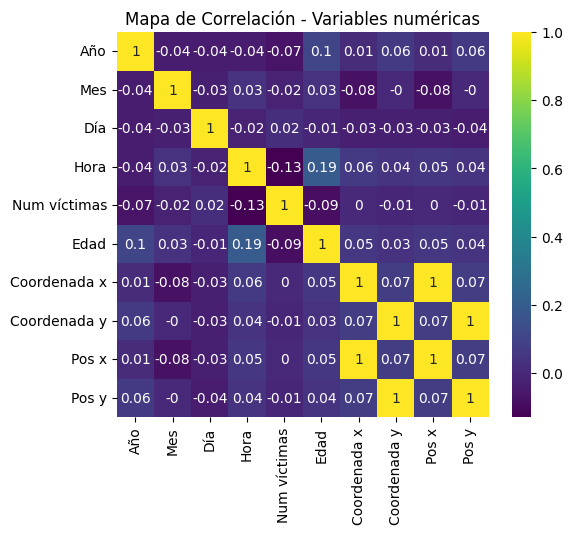

In [5]:
# Generamos un mapa de calor con las correlaciones de los todos los datos que contengan números 
dataNumerica = siniestrosLimpio.select_dtypes(include=['number']) 
corr = dataNumerica.corr().round(2)

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="viridis", annot=True)
plt.title('Mapa de Correlación - Variables numéricas')
plt.show()

Al analizar las variables numéricas de la matriz, se observan fuertes relaciones positivas entre las características Coordenada y Pos, lo cual era esperable.

También se observa una débil correlación positiva entre las variables Edad y Hora.

Las demás correlaciones son negativas, lo que también era esperable ya que el Num víctimas de un siniestro no se relaciona con una fecha u hora específica.

Dado que el objetivo de este proyecto es analizar los siniestros para disminuir la cantidad de víctimas fatales, se ha decidido comenzar la exploración con la variable Num víctimas.

### `Num víctimas`
- Cantidad de víctimas fatales por siniestro vial

In [6]:
siniestrosLimpio["Num víctimas"].describe()

count    717.000000
mean       1.061367
std        0.257024
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Num víctimas, dtype: float64

C:\Users\Eduar\AppData\Local\Temp\ipykernel_22044\1721376284.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_filtrado, x='Num víctimas', palette="Paired")


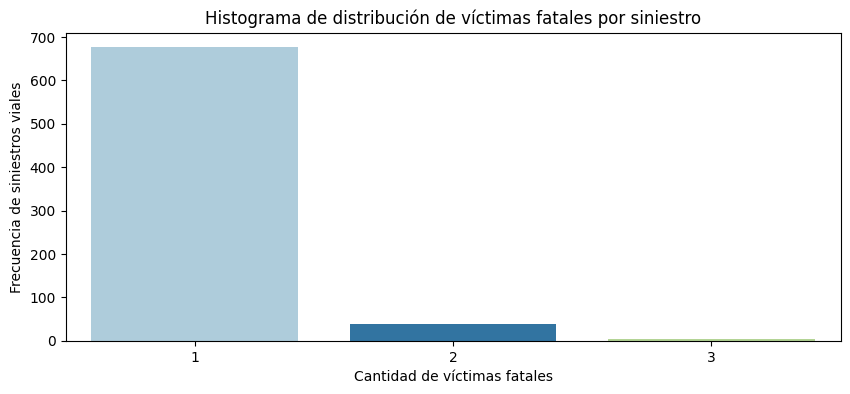

In [7]:
plt.figure(figsize=(10, 4))
# se filtran los valores sin datos o nulos 
df_filtrado = siniestrosLimpio[siniestrosLimpio["Num víctimas"] != 0]

#Se cuentan los datos de la columna y se calcula la frecuencia en que se distribuye
sns.countplot(df_filtrado, x='Num víctimas', palette="Paired")

plt.ylabel("Frecuencia de siniestros viales")
plt.xlabel("Cantidad de víctimas fatales")
plt.title("Histograma de distribución de víctimas fatales por siniestro")

plt.show()

#### **Conclusión**
1. La cantidad de víctimas fatales en los accidentes de tránsito suele ser de 1 (una).

2. De acuerdo a las estadísticas, el 75% de los accidentes de tránsito tienen 1 víctima.

3. Los accidentes con tres víctimas fatales son poco frecuentes.

#### Relación `Num vìctimas` con el tiempo - Distribución temporal

Se analizan los datos teniendo en cuenta diferentes horizontes temporales, para corroborar la existencia de algún tipo de evento o patrón importante.


In [8]:
# Agrupar por año y mes, y sumar el número de víctimas
rel_tiempo = siniestrosLimpio.groupby(['Año', 'Mes'])['Num víctimas'].sum().reset_index()
rel_tiempo

,Año,Mes,Num víctimas
0,2016,1,8
1,2016,2,12
2,2016,3,15
3,2016,4,11
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [9]:
#Para la realización del gráfico se transforman los datos a tipo int
rel_tiempo["Año"]= rel_tiempo["Año"].astype("Int64")
rel_tiempo["Mes"]= rel_tiempo["Mes"].astype("Int64")

rel_tiempo

,Año,Mes,Num víctimas
0,2016,1,8
1,2016,2,12
2,2016,3,15
3,2016,4,11
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [10]:
# Combinar AÑO y MES para obtener una sola variable de tiempo, creando la columna "Fecha" como str
rel_tiempo["Fecha"] = rel_tiempo["Año"].astype(str) + '-' + rel_tiempo["Mes"].astype(str)

# Convertir la variable de tiempo a formato datetime
rel_tiempo["Fecha"] = pd.to_datetime(rel_tiempo["Fecha"])

# Ordenar el DataFrame por fecha para que tenga orden cronológico
rel_tiempo = rel_tiempo.sort_values("Fecha")

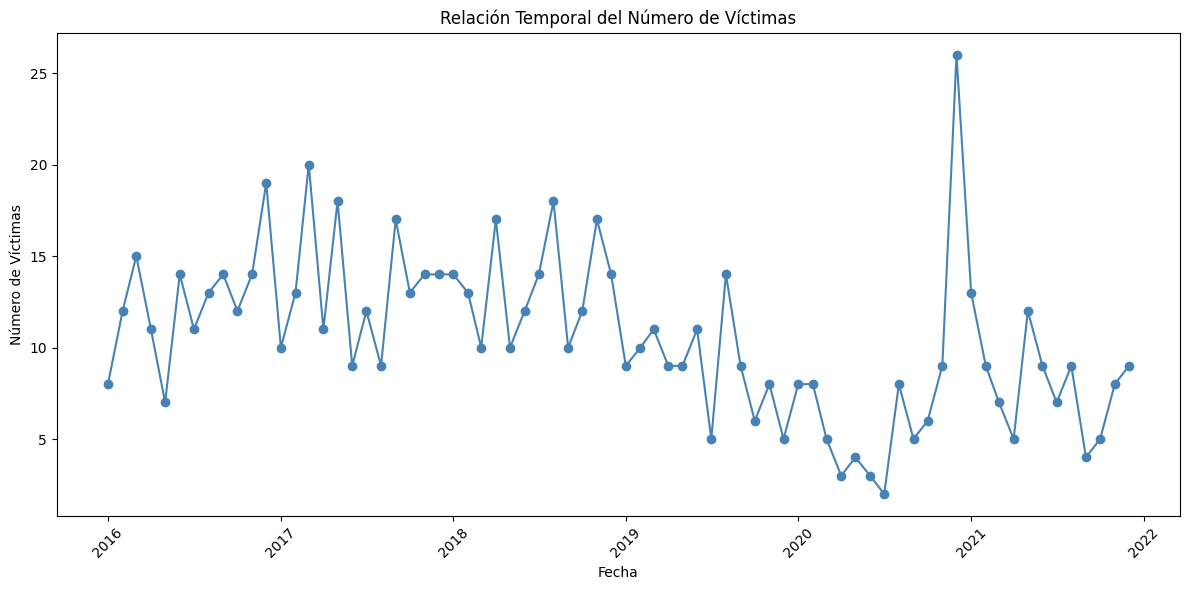

In [11]:
# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(rel_tiempo["Fecha"], rel_tiempo["Num víctimas"], marker='o', color='steelblue')

# Añadir títulos y etiquetas
plt.title('Relación Temporal del Número de Víctimas')
plt.xlabel('Fecha')
plt.ylabel('Número de Víctimas')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### **Conclusión**
1. Gráfico de víctimas fatales:

El análisis temporal del número de víctimas fatales en el gráfico revela que 2017 y 2018 concentraron la mayor cantidad de siniestros fatales. A partir de entonces, se observa una disminución sostenida en los años siguientes, con un pico excepcional a finales de 2020, que superó el mayor número de víctimas fatales mensuales de todo el período analizado (26 víctimas).

2. Influencia del COVID-19:

La llegada de la pandemia de COVID-19 en 2020 impactó significativamente las estadísticas de siniestros viales, lo que debe ser considerado al analizar la tendencia temporal.
## Distribución temporal de víctimas 

### Distribución mensual de víctimas fatales

Se crea un gráfico de barras que muestra la cantidad de víctimas por mes y agrega etiquetas de número de víctimas en cada barra.

C:\Users\Eduar\AppData\Local\Temp\ipykernel_22044\1541928229.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Mes', y='Num víctimas', data=data, palette="winter")


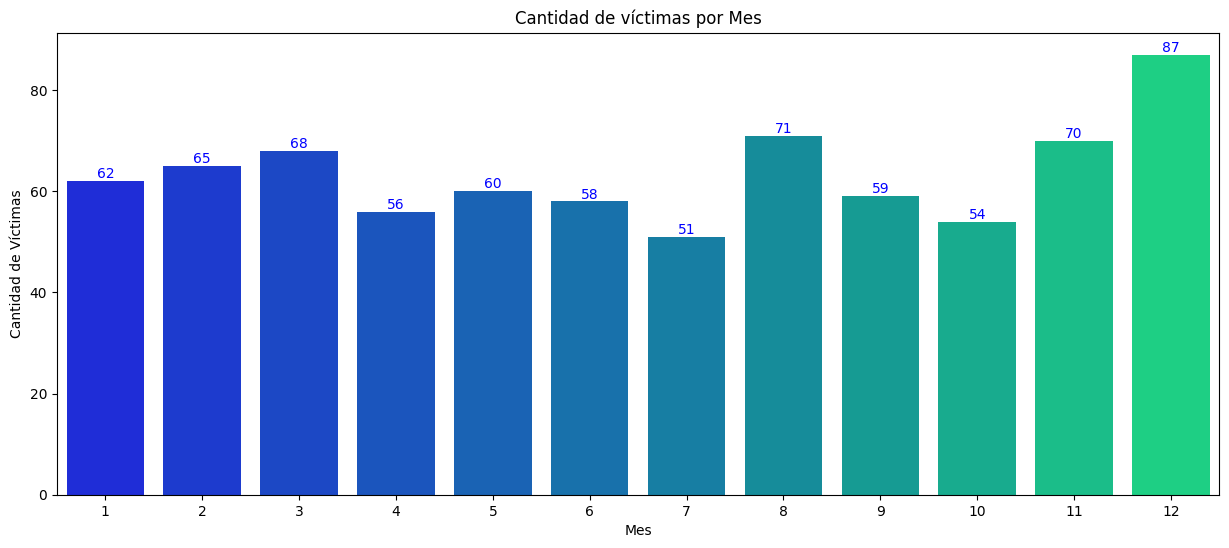

In [12]:
# Se agrupa por la cantidad de víctimas por mes
data = siniestrosLimpio.groupby(['Mes'])['Num víctimas'].sum().reset_index()
data["Mes"]=data["Mes"].astype("Int64")

# Se grafica
plt.figure(figsize=(15,6))

ax = sns.barplot(x='Mes', y='Num víctimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por Mes')
ax.set_xlabel('Mes') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='blue', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

#### Distribución diaria de víctimas fatales

Se crea un gráfico de barras que muestra la cantidad de víctimas por día y agrega etiquetas de número de víctimas en cada barra.


C:\Users\Eduar\AppData\Local\Temp\ipykernel_22044\3684825395.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Día', y='Num víctimas', data=data, palette="winter")


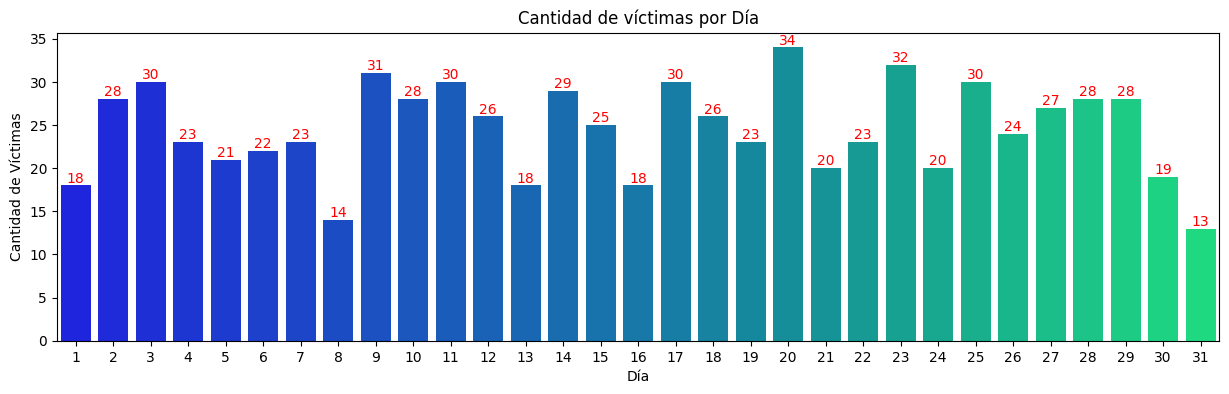

In [13]:
# Se agrupa por la cantidad de víctimas por dia
data = siniestrosLimpio.groupby(['Día'])['Num víctimas'].sum().reset_index()
data["Día"]=data["Día"].astype("Int64")

# Se grafica
plt.figure(figsize=(15,4))

ax = sns.barplot(x='Día', y='Num víctimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por Día')
ax.set_xlabel('Día') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='red', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

C:\Users\Eduar\AppData\Local\Temp\ipykernel_22044\4181140430.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Día semana', y='Num víctimas', data=data, palette="winter")


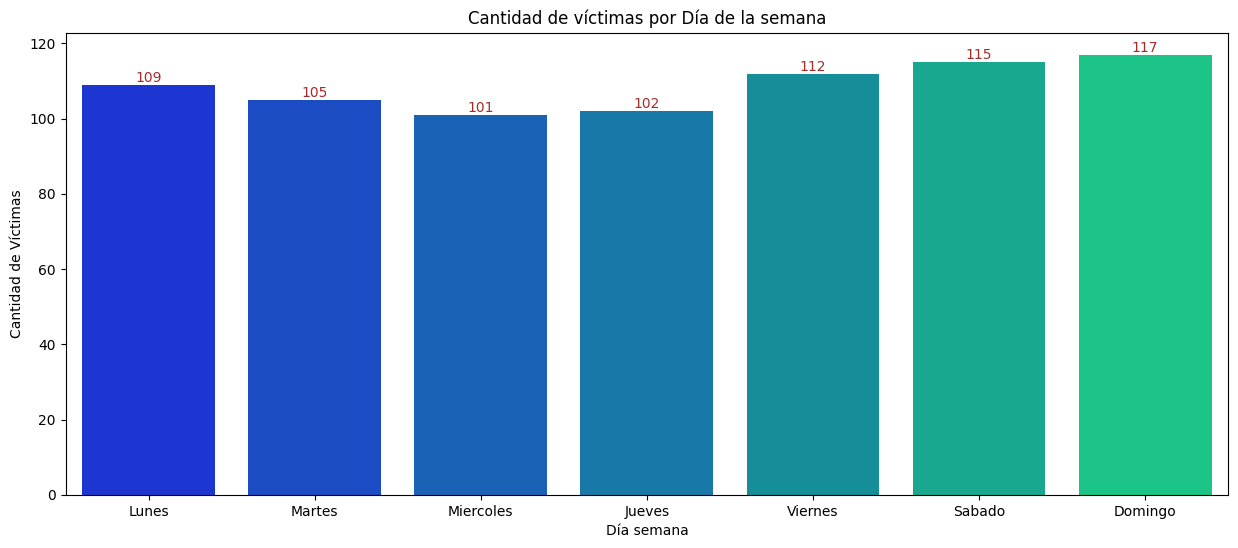

In [14]:
# Se agrupa por la cantidad de víctimas por dia semana
data = siniestrosLimpio.groupby(['Día semana'])['Num víctimas'].sum().reset_index()


# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')



# Se grafica
plt.figure(figsize=(15,6))

ax = sns.barplot(x='Día semana', y='Num víctimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por Día de la semana')
ax.set_xlabel('Día semana') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='brown', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

#### Distribución relacionando horas y días, de víctimas fatales

Se crea un mapa de calor donde el eje x representa las horas del día, el eje y representa los días de la semana y el color de cada celda indica el número de víctimas. Se utiliza Seaborn para crear el mapa de calor y el argumento annot=True agrega los valores numéricos en las celdas del mapa de calor.



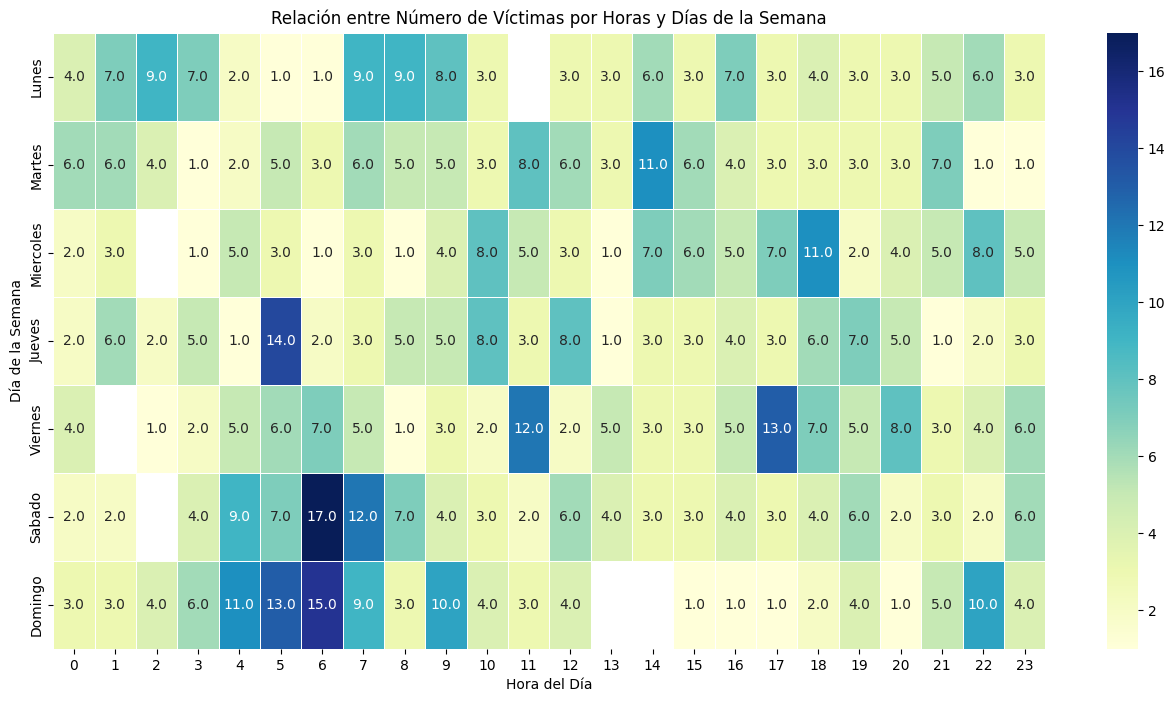

In [15]:
#Agrupa los datos en cantidad de victimas por dia de la semana y horas 
data = siniestrosLimpio.groupby(['Día semana', "Hora"])['Num víctimas'].sum().reset_index()
data["Hora"]=data["Hora"].astype("Int64")

# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')

# Crear una tabla pivot para los datos
pivot_data = data.pivot_table(index= 'Día semana', columns='Hora', values='Num víctimas', aggfunc='sum')
pivot_data = pivot_data.reindex(orden_dias_semana)

# Crear un mapa de calor (heatmap)
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=0.5)

# Configurar etiquetas y título
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Relación entre Número de Víctimas por Horas y Días de la Semana')

# Mostrar el gráfico
plt.show()

#### **Conclusión**
1. Mes con mayor cantidad de víctimas:

Original: El mes con mayor cantidad de víctimas fatales (86) es Diciembre.
Reescrito: Diciembre se alza como el mes con el mayor número de víctimas fatales, con un total de 86.
2. Día y días con mayor cantidad de víctimas:

Original: El Día 20 de cada mes es el que lleva el mayor número de víctimas y los días Sábado y Domingo tienen la suma de 114 víctimas fatales, siendo la mayor cantidad.
Reescrito: El día 20 de cada mes presenta la mayor cantidad de víctimas fatales. A su vez, los sábados y domingos acumulan la cifra más alta de víctimas, con un total de 114.
3. Mapa de calor y horas con mayor cantidad de víctimas:

Original: El mapa de calor indica que los días de fin de semana, en especial sábados y domingos se encuentran con un número más alto de víctimas fatales, siendo las horas entre 03.00 hs y 09.00 hs
Reescrito: El mapa de calor revela que los fines de semana, especialmente sábados y domingos, concentran la mayor cantidad de víctimas fatales. Las horas más críticas se ubican entre las 3:00 AM y las 9:00 AM.
4. Horarios con mayor peligrosidad:

Original: Puede decirse que los horarios con mayor peligrosidad tienen que ver con el ingreso laboral (05:00 hs - 09:00 hs), el horario del mediodía (12:00 hs - 14:00 hs) y salida del trabajo (17:00 hs - 18:00 hs). Durante la madrugada existen pocos siniestros. Y los fines de semana los la cantidad de siniestros es poca pero con mayor cantidad de víctimas
Reescrito: Los horarios de mayor riesgo se asocian con el ingreso laboral (5:00 AM - 9:00 AM), el horario del mediodía (12:00 PM - 2:00 PM) y la salida del trabajo (5:00 PM - 6:00 PM). La madrugada presenta una baja incidencia de siniestros, mientras que los fines de semana, aunque con menos eventos, se observa un mayor número de víctimas fatales.

### `Edad` de las víctimas

Se crea un histograma de edades de las víctimas fatales y se utiliza el mismo eje para mostrar las estadísticas de la columna edades a través de un boxplot



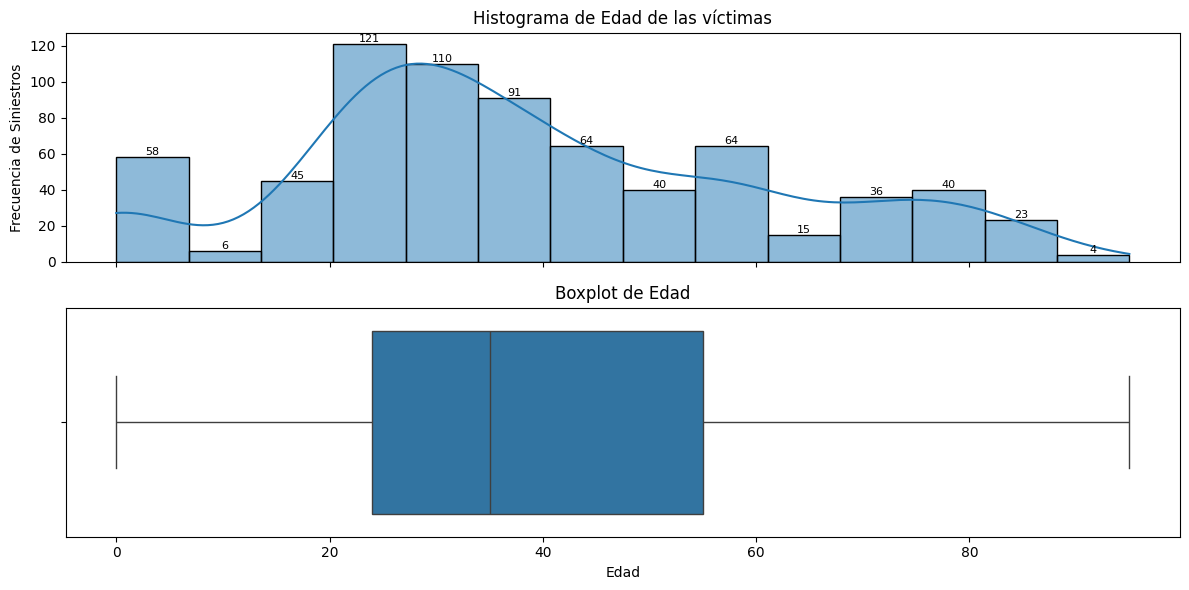

In [16]:
# Se crea una figura con un solo eje x compartido para tener dos gráficos en uno
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Se grafica el histograma de la edad
sns.histplot(siniestrosLimpio['Edad'], kde=True, ax=ax[0]) #se agrega la línea de suavizado
ax[0].set_title('Histograma de Edad de las víctimas') ; ax[0].set_ylabel('Frecuencia de Siniestros')

# Agregar etiquetas de datos en el histograma
for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black')

# Se grafica el boxplot de la edad
sns.boxplot(x=siniestrosLimpio['Edad'], ax=ax[1])
ax[1].set_title('Boxplot de Edad') ; ax[1].set_xlabel('Edad')

# Se ajusta y muestra el gráfico
plt.tight_layout()
plt.show()

In [17]:
siniestrosLimpio["Edad"].describe()

count    717.000000
mean      39.050209
std       22.010669
min        0.000000
25%       24.000000
50%       35.000000
75%       55.000000
max       95.000000
Name: Edad, dtype: float64

En una vista general, se observa que el 75% de las víctimas fatales no supera los 55 años, con una mediana de 39 años.

Al analizar la distribución del histograma, se concluye que la mayor cantidad de víctimas fatales se concentra entre los 20 y 40 años de edad.

### Relación de `Edad` de las víctimas con la `Hora` del siniestro

Se realiza el análisis de ésta relación que resultó positiva en la matriz de correlación en las variables numéricas.
Se crea un gráfico de dispersión que representa la relación entre la edad de las víctimas en el eje x y la hora del siniestro en el eje y. 

In [18]:
#Agrupa los datos en cantidad de victimas por edad y horas 
data = df.groupby(['Edad', "Hora"])['Num víctimas'].sum().reset_index()
data["Edad"]=data["Edad"].astype("Int64")
data["Hora"]=data["Hora"].astype("Int64")



# Crear un gráfico de dispersión para la relación entre edad y hora
plt.figure(figsize=(12, 6))

sns.scatterplot(data=df, x='Edad', y='Hora', alpha=0.5, label='Relación Edad-Hora') # se utiliza alpha para transparencia de los puntos
plt.xlabel('Edad de las Víctimas')
plt.ylabel('Hora del Siniestro')
plt.title('Relación entre Edad de las Víctimas y Hora del Siniestro')

# Agregar una leyenda
plt.legend(loc='best') 
# Mostrar el gráfico
plt.show()

NameError: name 'df' is not defined

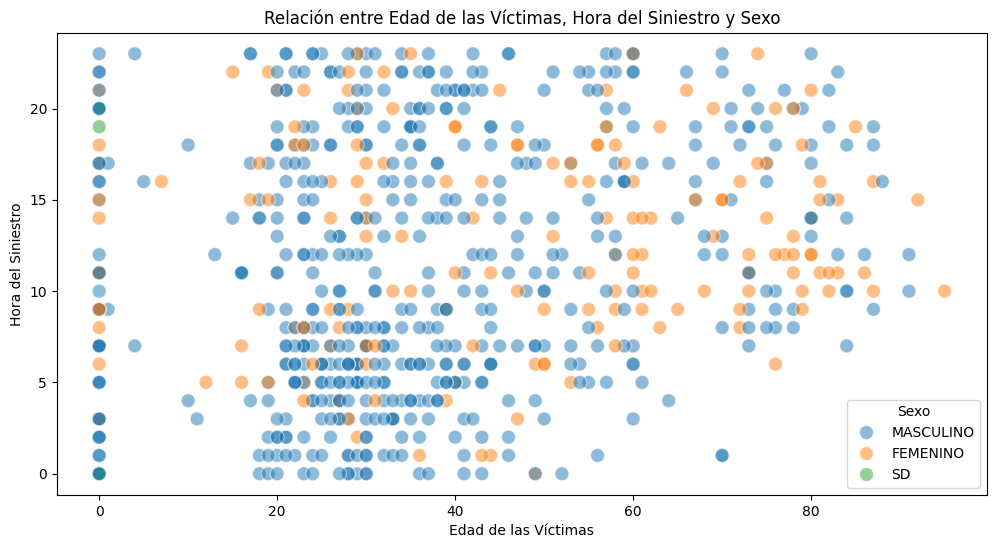

In [ ]:
#Agrupa los datos en cantidad de victimas por edad y horas 
data = df.groupby(['Edad', "Hora", "Sexo"])['Num víctimas'].sum().reset_index()
data["Edad"]=data["Edad"].astype("Int64")
data["Hora"]=data["Hora"].astype("Int64")

# Crear un gráfico de dispersión para la relación entre edad, hora y sexo
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Edad', y='Hora', hue='Sexo', alpha=0.5, palette='tab10', s=100)

# Agregar etiquetas a los ejes
plt.xlabel('Edad de las Víctimas')
plt.ylabel('Hora del Siniestro')
plt.title('Relación entre Edad de las Víctimas, Hora del Siniestro y Sexo')

# Agregar una leyenda
plt.legend(title='Sexo')

# Mostrar el gráfico
plt.show()

#### **Conclusión**
- Las gráficas de dispersión presentadas arriba, señalan la relación entre las edades de 20 a 40 años de las víctimas y las horas de mayor cantidad de ocurrencia de siniestros viales; siendo entre las 5 a 9 hs y 17 a 18 hs
- Cuando se le agrega la distinción por Sexo, se muestra una mayor cantidad de víctimas `Masculinas`, con respecto a las `Femeninas` en ésta relación

### Distribución etaria  de víctimas según `Sexo`

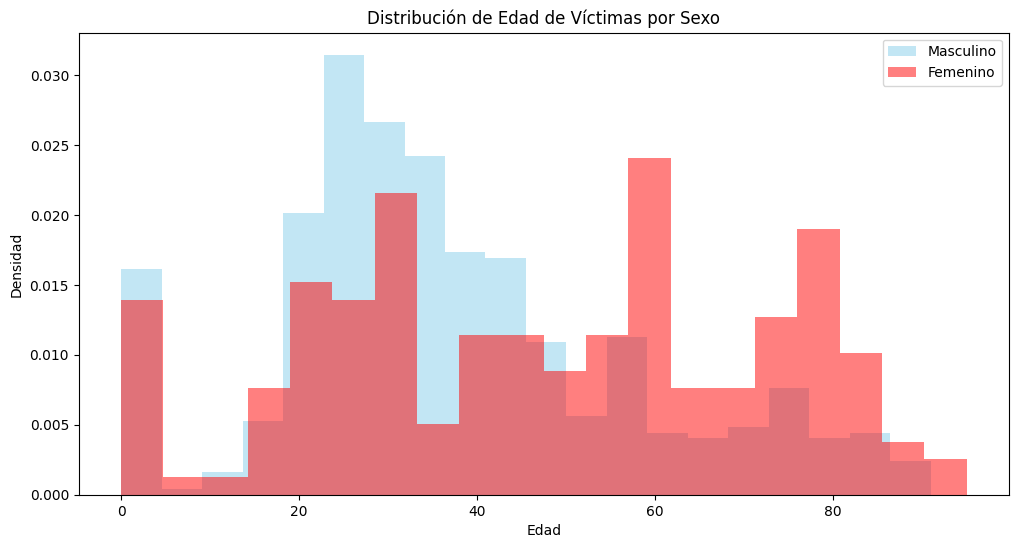

In [ ]:
# Filtrar por sexo masculino
masculino = df[df['Sexo'] == 'MASCULINO']['Edad'].dropna()

# Filtrar por sexo femenino
femenino = df[df['Sexo'] == 'FEMENINO']['Edad'].dropna()

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.hist(masculino, bins=20, alpha=0.5, color='skyblue', label='Masculino', density=True)
plt.hist(femenino, bins=20, alpha=0.5, color='red', label='Femenino', density=True)
plt.title('Distribución de Edad de Víctimas por Sexo')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend()
plt.show()

#### **Conclusión**
El gráfico muestra dos histogramas sobre el mismo eje a fin de poder comparar de manera más visual la diferencia entre las víctimas de ambos sexos.
- como resultado arroja que las victimas de sexo Masculino son de 20 a 40 años de Edad
- las víctimas de sexo Femenino son de entre 40, 60 y 80 años de Edad.

### Distribución temporal de las Edades de las víctimas

C:\Users\Eduar\AppData\Local\Temp\ipykernel_9044\707867547.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Año', y='Edad', data=df, palette="winter")


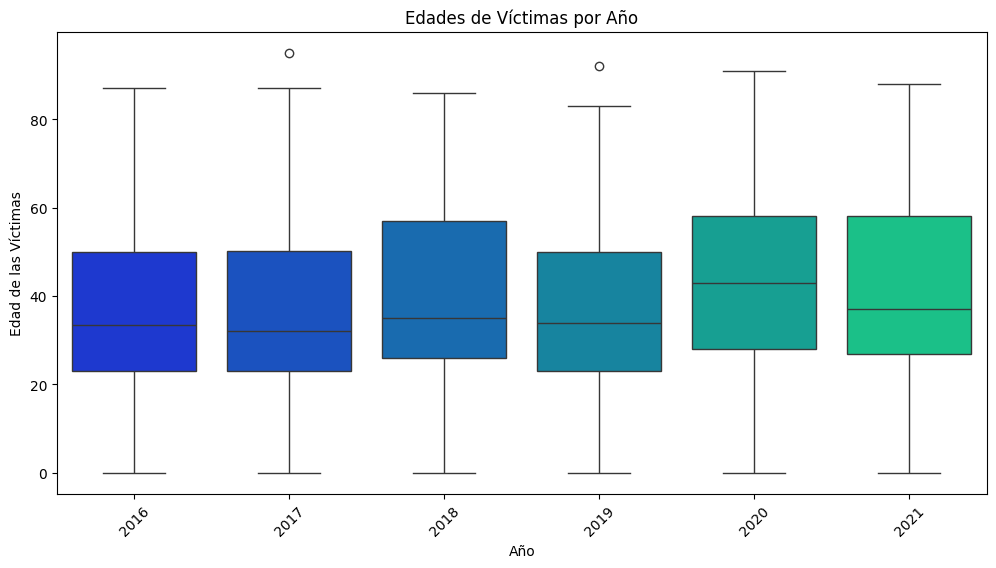

In [ ]:

#Agrupa los datos en cantidad de victimas por edad y  año
data = df.groupby(['Edad', "Año"])['Num víctimas'].sum().reset_index()


#Se crea el gráfico de boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Año', y='Edad', data=df, palette="winter")

plt.title('Edades de Víctimas por Año') ; plt.xlabel('Año') ; plt.ylabel('Edad de las Víctimas')
# Cambia el formato de las etiquetas del eje x a enteros
plt.xticks(rotation=45)
# Se muestra el gráfico
plt.show()

#### **Conclusión**
El gráfico confirma que a través del tiempo, la mediana de la edad de las víctimas sigue siendo alrrededor de los 39 años y supera esta barrera en el año 2020

### Distribución espacial de los siniestros con víctimas `Coordenadas`

Para usar Geopandas, primero se define un sistema de referencia de coordenadas (CRS) y éste le dice a Python como se relacionan estas coordenadas que instanciamos con los diferentes lugares del planeta

c:\Users\Eduar\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

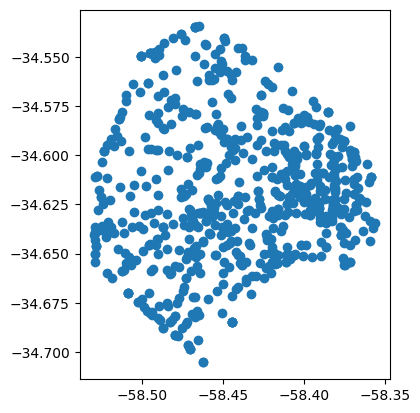

In [ ]:
# Iniciamos CRS

crs={'init':'epsg:4326'}


#Definimos la geometría según nuestro dataset
geometry=[Point(xy) for xy in zip(df["Pos x"], df["Pos y"])]

#Ua vez que tenemos el sistema de referencia decoordenadas y la geometría; se procede a la carga de los datos
geodata=gpd.GeoDataFrame(df,crs=crs, geometry=geometry)

#Se imprime el resultante que luego será introducido en un mapa
geodata.plot()

Una vez que el mapa de geometría está listo, se debe cargar el archivo de las comunas del la ciudad de Buenos Aires que se extrajo de https://data.buenosaires.gob.ar/dataset/comunas/resource/Juqdkmgo-612222-resource que debe ser un archivo Shapefile (SHP)

Text(158.98305973900304, 0.5, 'Latitud')

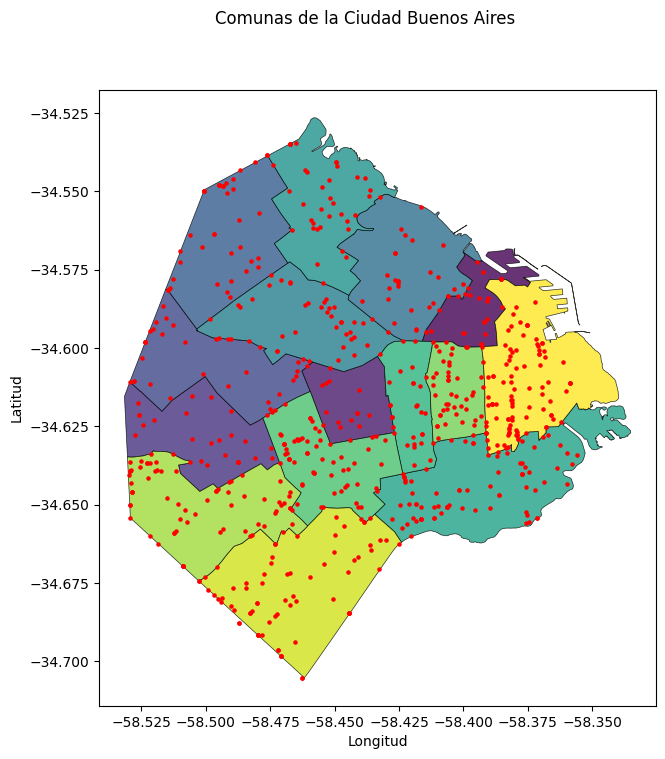

In [ ]:
#Extraer el archivo
shapefile = gpd.read_file(r"./comunas/comunas_wgs84.shp")

#Se realiza sobre el mapa de CABA la presentación de los puntos de referencia a los siniestros viales

#Crea ejes y figuras
fig, ax = plt.subplots(figsize=(10,8))

#Dibujar el Shapefile
shapefile.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=0.8,linewidth=0.5,cmap="viridis")

#Dibujar los datos geoespaciales
geodata.plot(ax=ax, color='red', markersize=5);

#Agregar título y etiquetas de ejes
fig.suptitle('Comunas de la Ciudad Buenos Aires', fontsize=12)
ax.set_xlabel('Longitud', fontsize=10)
ax.set_ylabel('Latitud', fontsize='medium')

#### **Conclusión**
- La gráfica muestra la concentración de los puntos rojos representando siniestros con víctimas fatales, hacia la zona Este del mapa de CABA sobre la comuna 1 y 4

#### **Conclusión**
- La gráfica muestra la concentración de los puntos rojos representando siniestros con víctimas fatales, hacia la zona Este del mapa de CABA sobre la comuna 1 y 4



C:\Users\Eduar\AppData\Local\Temp\ipykernel_9044\713621936.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(df, x='Tipo de calle', palette="winter")


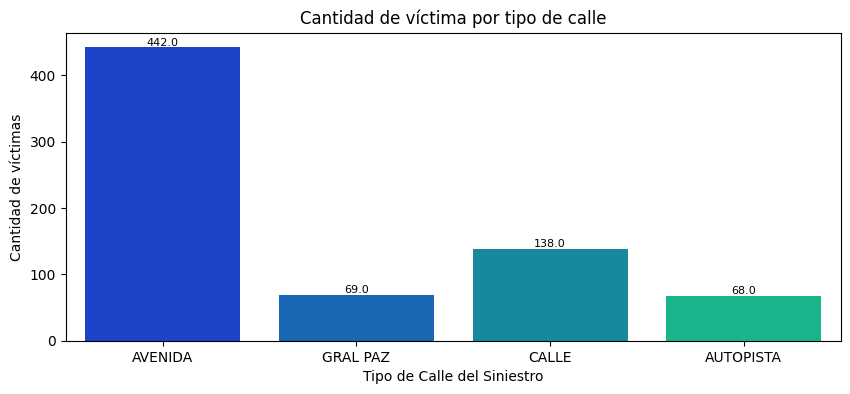

In [ ]:
#Se crea el gráfico de barras
plt.figure(figsize=(10, 4))

ax=sns.countplot(df, x='Tipo de calle', palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

#Se titulan los ejes
plt.xlabel('Tipo de Calle del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctima por tipo de calle')

plt.show()

#### **Conclusión**
- Del análisis del gráfico resulta que el mayor número de víctimas fatales se producen en `Avenida`; secundado por `Calle`.

### Distribución de `Participantes` en los siniestros



C:\Users\Eduar\AppData\Local\Temp\ipykernel_9044\3601797418.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(df, x="Participantes", palette="winter")


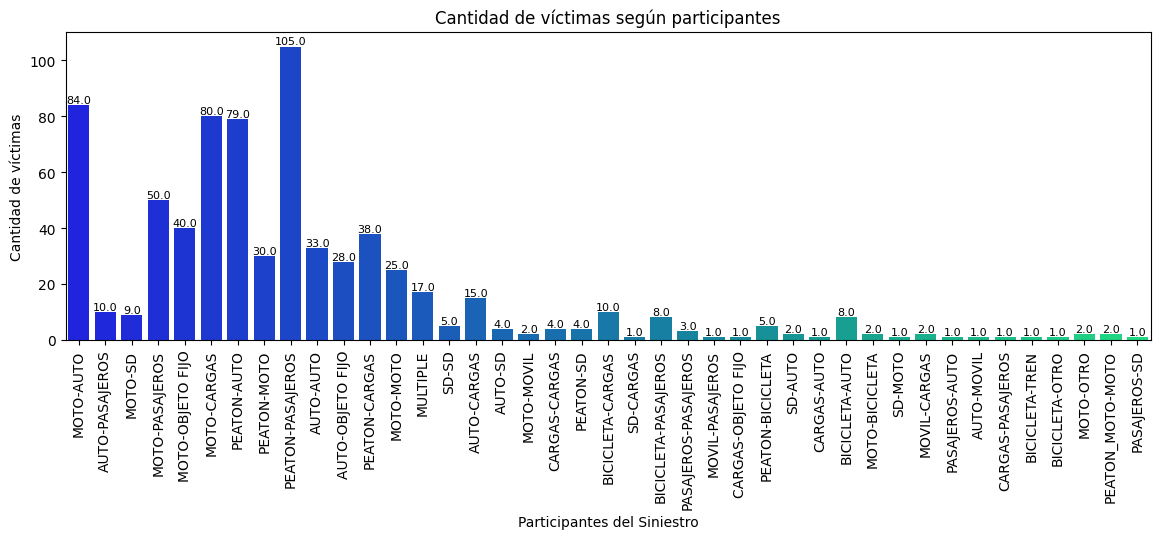

In [ ]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Participantes", palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

#Se ubican los titulos de las barras en 90 grados
plt.xticks(rotation=90)

#Se titulan los ejes
plt.xlabel('Participantes del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas según participantes')

plt.show()

#### **Conclusión**
- Los valores de participación que concentran más víctimas están en `PEATON-PASAJEROS`, esto según el diccionario de datos, se refiere a Peatón: es cualquier víctima distinta de cualquier ocupante de un vehículo; Pasajero: es cualquier persona que se encuentra dentro, descendiendo o ascendiendo del transporte público u omnibús de larga distancia.
- Le siguen en importancia de víctimas `MOTO-AUTO` , `PEATON-AUTO` y `MOTO-CARGAS`

En la columna `Participantes` puede interpretarse que la primer palabra se relaciona a quien fue la `Víctima` y la segunda palabra se refiere al `Acusado`

### Distribución de `Acusados` en los siniestros

C:\Users\Eduar\AppData\Local\Temp\ipykernel_9044\2202415886.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(df, x="Acusado", palette="winter")


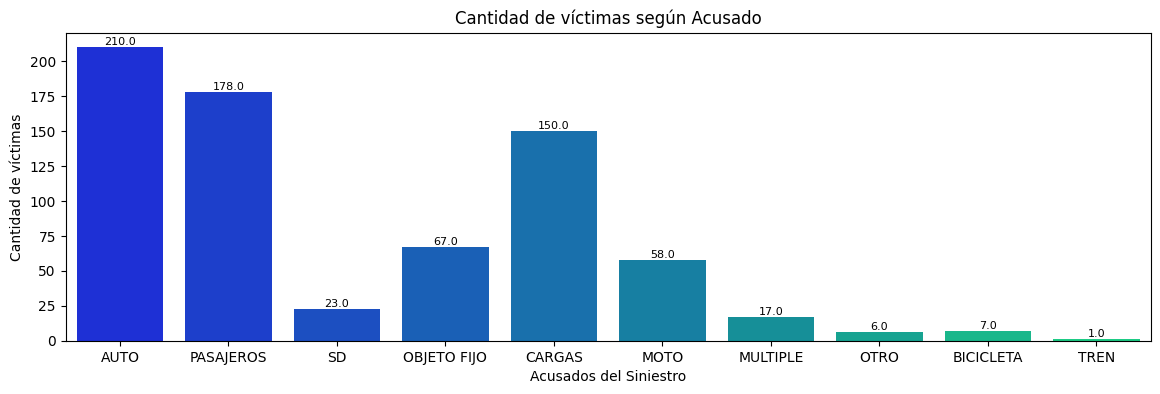

In [ ]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Acusado", palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)


#Se titulan los ejes
plt.xlabel('Acusados del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas según Acusado')

plt.show()

#### **Conclusión**
- Se puede visualizar que los que causan más víctimas son los  `Autos`, `Cargas` y `Pasajeros`. Esto se relaciona con el punto anterior.

### Distribución de `Víctimas` en los siniestros

C:\Users\Eduar\AppData\Local\Temp\ipykernel_9044\3606964637.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(df, x="Victima", palette="winter")


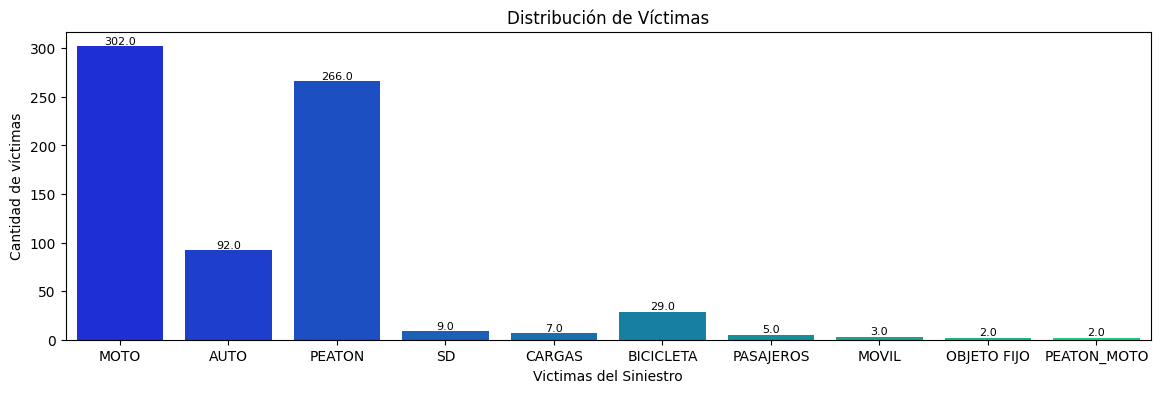

In [ ]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Victima", palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)


#Se titulan los ejes
plt.xlabel('Victimas del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Distribución de Víctimas')

plt.show()

#### **Conclusión**
- Se puede visualizar que las víctimas son  `Moto`, `Peaton` y `Carga`. Esto se relaciona con ambos puntos anteriores.

### Matriz de confusión 

Se crea una tabla ce contingencia que relacione los datos de las columnas `Víctima` y `Acusado` para analizar de manera más visual los datos de los siniestros y sus participantes.

In [ ]:
tabla_contingencia = pd.crosstab(df['Victima'], df['Acusado'])

# Visualizar la tabla de contingencia
tabla_contingencia

Acusado,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
Victima,,,,,,,,,,
AUTO,33,0,15,0,3,26,1,10,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,84,2,80,25,8,40,4,50,9,0
MOVIL,0,0,2,0,0,0,0,1,0,0
OBJETO FIJO,2,0,0,0,0,0,0,0,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,79,5,38,30,5,0,0,105,4,0
PEATON_MOTO,0,0,0,2,0,0,0,0,0,0


#### **Conclusión**
Aquí se encuentran de manera más clara en sus resultados la intervención en cada siniestro.
- Cuando el acusado es `Auto`, la mayoría de las víctimas son Autos, Motos y Peatones.
- Cuando el acusado es `Cargas`, las victimas son variadas; siendo Motos y Peatones los más encontrados.
- Cuando el acusado es `Pasajeros`, las víctimas son principalmente Peatones y Motos.

La frecuencia de víctimas Motos y Peatones es alta, y se relacionan con casi todos los tipos de Acusados.


### Proporción de víctimas por `Sexo`

Text(0.5, 1.0, 'Proporción de Víctimas por Sexo')

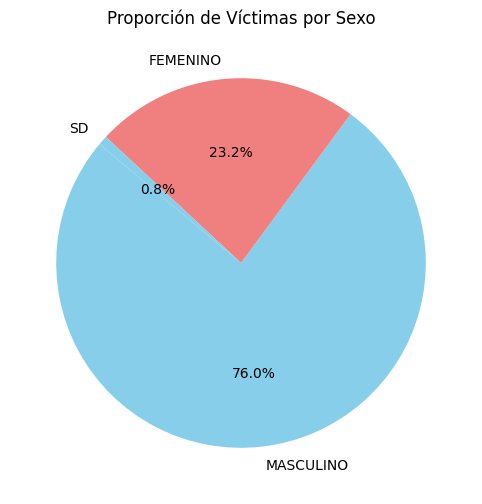

In [ ]:
# Calcular la proporción de víctimas por sexo
proporcion = df['Sexo'].value_counts(normalize=True) * 100

# Preparar los datos para el gráfico de torta
labels = proporcion.index
sizes = proporcion.values

# Crear el gráfico de torta
plt.figure(figsize=(12, 6))

# Gráfico de torta

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Proporción de Víctimas por Sexo')

### Distribución de los roles de las víctimas por `Sexo`

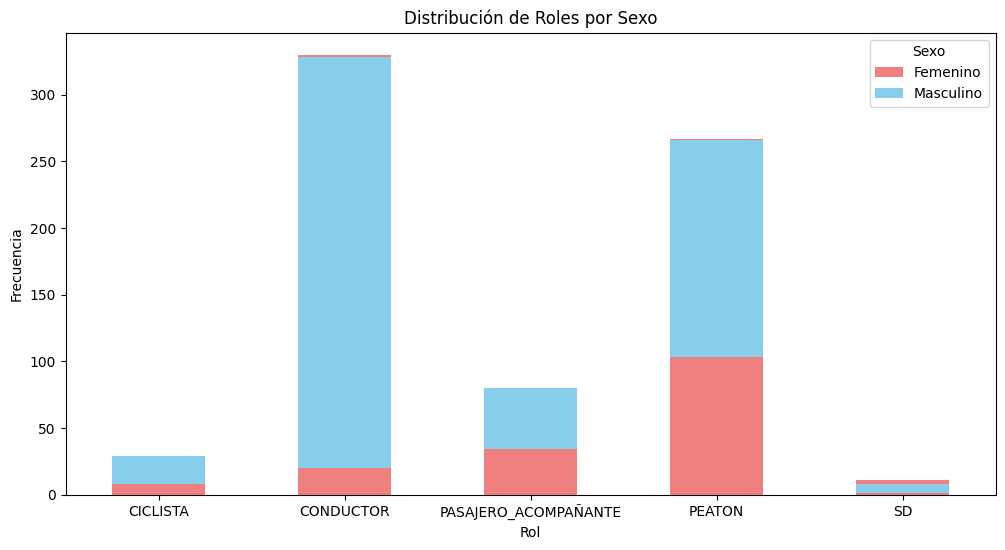

In [ ]:
# Crear una tabla de contingencia
tabla_contingencia = pd.crosstab(df['Rol'], df['Sexo'])

# Crear un gráfico de barras apiladas
ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(12, 6), color=["lightcoral",'skyblue'])
plt.title('Distribución de Roles por Sexo')
plt.xlabel('Rol')
plt.ylabel('Frecuencia')

# Agregar una leyenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Femenino', 'Masculino'], title='Sexo')

plt.xticks(rotation=0)
plt.show()

#### **Conclusión**
La distribución por roles de las víctimas muestra que
- la mayor cantidad de siniestros las victimas tienen como rol `Conductor`, seguida por `Peatón`.
- para las víctimas de sexo `Masculino`, el rol más frecuente en los siniestros es como conductor, seguido por peatón.
- para las víctimas de sexo `Femenino`, el rol más frecuente en los siniestros es como peatón, seguido por pasajero-acompañante

### Distribucíon de víctimas según `sexo` y `tipo de vehículo`

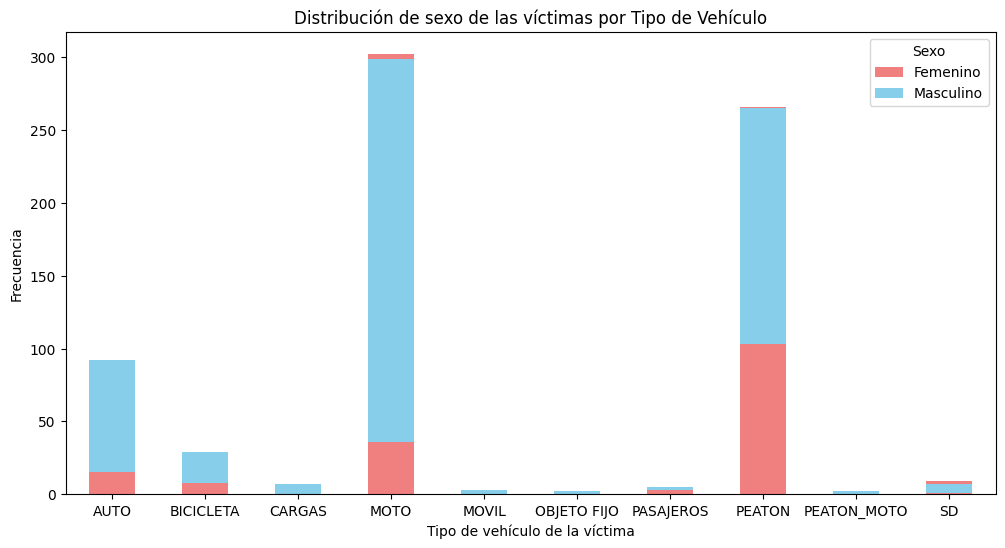

In [ ]:
# Crear una tabla de contingencia
tabla_contingencia = pd.crosstab(df['Victima'], df['Sexo'])

# Crear un gráfico de barras apiladas
ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(12, 6), color=["lightcoral",'skyblue'])
plt.title('Distribución de sexo de las víctimas por Tipo de Vehículo')
plt.xlabel('Tipo de vehículo de la víctima')
plt.ylabel('Frecuencia')

# Agregar una leyenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Femenino', 'Masculino'], title='Sexo')

plt.xticks(rotation=0)
plt.show()

#### **Conclusión**

- La mayor cantidad de accidentes con víctimas fatales son en `Moto` y además con más proporción de Masculinos
- Los `Peatones`, son el segundo tipo de víctima, en el que la mayor proporción son Masculinos pero con menor diferencia que en la primera.

In [77]:
data = pd.read_csv('siniestosLimpio.csv')
data.head(3)

,Id,Fecha,Año,Mes,Día,Día semana,Hora completa,Hora,Num víctimas,Participantes,...,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,Xy (caba),Coordenada x,Coordenada y,Pos x,Pos y
0,2016-0001,2016-01-01,2016,1,1,Viernes,04:00:00,4.0,1,MOTO-AUTO,...,AVENIDA,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",Comuna Comuna 8,Point (98896.78238426 93532.43437792),98896.782384,93532.434378,-58.475340,-34.687570
1,2016-0002,2016-01-02,2016,1,2,Sabado,01:15:00,1.0,1,AUTO-PASAJEROS,...,GRAL PAZ,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",Comuna Comuna 9,Point (95832.05571093 95505.41641999),95832.055711,95505.416420,-58.508775,-34.669777
2,2016-0003,2016-01-03,2016,1,3,Domingo,07:00:00,7.0,1,MOTO-AUTO,...,AVENIDA,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,Comuna Comuna 1,Point (106684.29090040 99706.57687843),106684.290900,99706.576878,-58.390403,-34.631894


In [78]:
#A continuacion leemos la informacion del .xlsx y mostramos sus primeras 3 filas:
data = pd.read_excel('homicidios.xlsx')
data.head(3)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO


In [79]:
#Mostramos em forma de lista todas las columnas y el numero de datos nulos que tiene cada una de ellas
data.isnull().sum()

ID                         0
N_VICTIMAS                 0
FECHA                      0
AAAA                       0
MM                         0
DD                         0
HORA                       0
HH                         0
LUGAR_DEL_HECHO            0
TIPO_DE_CALLE              0
Calle                      1
Altura                   567
Cruce                    171
Dirección Normalizada      8
COMUNA                     0
XY (CABA)                  0
pos x                      0
pos y                      0
PARTICIPANTES              0
VICTIMA                    0
ACUSADO                    0
dtype: int64

In [80]:
#mostramos ahora la frecuencia de aparición de cada valor único en una columna. 
data.value_counts


<bound method DataFrame.value_counts of             ID  N_VICTIMAS      FECHA  AAAA  MM  DD      HORA  HH  \
0    2016-0001           1 2016-01-01  2016   1   1  04:00:00   4   
1    2016-0002           1 2016-01-02  2016   1   2  01:15:00   1   
2    2016-0003           1 2016-01-03  2016   1   3  07:00:00   7   
3    2016-0004           1 2016-01-10  2016   1  10  00:00:00   0   
4    2016-0005           1 2016-01-21  2016   1  21  05:20:00   5   
..         ...         ...        ...   ...  ..  ..       ...  ..   
691  2021-0093           1 2021-12-13  2021  12  13  17:10:00  17   
692  2021-0094           1 2021-12-20  2021  12  20  01:10:00   1   
693  2021-0095           1 2021-12-30  2021  12  30  00:43:00   0   
694  2021-0096           1 2021-12-15  2021  12  15  10:30:00  10   
695  2021-0097           1 2021-11-18  2021  11  18  06:10:00   6   

                               LUGAR_DEL_HECHO TIPO_DE_CALLE  ...  Altura  \
0    AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ       A

ACUSADO
AUTO           204
PASAJEROS      173
CARGAS         146
OBJETO FIJO     62
MOTO            57
SD              23
MULTIPLE        17
BICICLETA        7
OTRO             6
TREN             1
Name: count, dtype: int64


<Axes: >

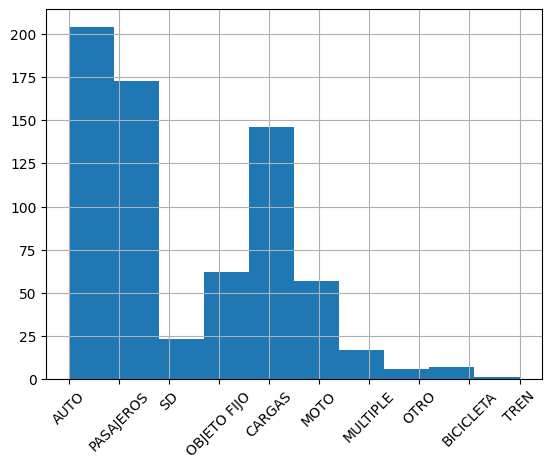

In [81]:
frecuencias = data["ACUSADO"].value_counts()

# Rotar las etiquetas 45 grados
plt.xticks(rotation=45)

# Mostrar las frecuencias
print(frecuencias)
data["ACUSADO"].hist()

VICTIMA
MOTO           295
PEATON         264
AUTO            83
BICICLETA       29
SD               9
CARGAS           7
PASAJEROS        5
MOVIL            2
OBJETO FIJO      1
PEATON_MOTO      1
Name: count, dtype: int64


<Axes: >

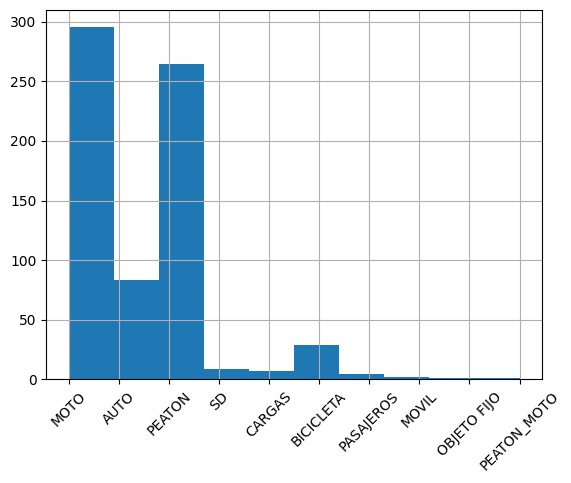

In [82]:
frecuencias = data["VICTIMA"].value_counts()

# Rotar las etiquetas 45 grados
plt.xticks(rotation=45)

# Mostrar las frecuencias
print(frecuencias)
data["VICTIMA"].hist()

COMUNA
1     90
4     76
9     73
8     65
7     60
3     45
15    44
13    40
12    37
14    35
11    32
10    29
2     25
5     22
6     21
0      2
Name: count, dtype: int64


<Axes: >

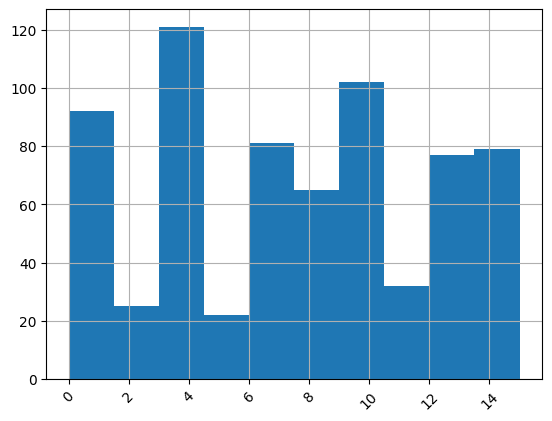

In [83]:
frecuencias = data["COMUNA"].value_counts()

# Rotar las etiquetas 45 grados
plt.xticks(rotation=45)

# Mostrar las frecuencias
print(frecuencias)
data["COMUNA"].hist()

COMUNA
1     90
4     76
9     73
8     65
7     60
3     45
15    44
13    40
12    37
14    35
11    32
10    29
2     25
5     22
6     21
0      2
Name: count, dtype: int64


<Axes: >

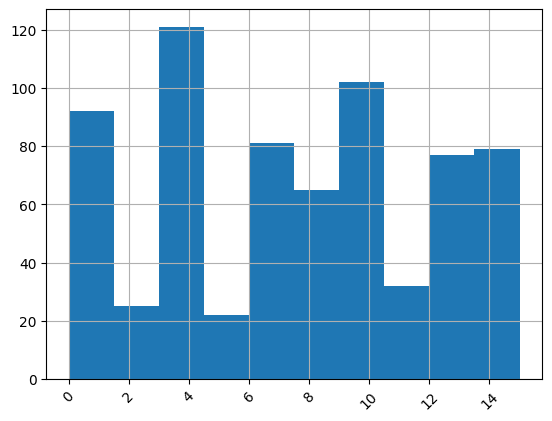

In [84]:
frecuencias = data["COMUNA"].value_counts()

# Rotar las etiquetas 45 grados
plt.xticks(rotation=45)

# Mostrar las frecuencias
print(frecuencias)
data["COMUNA"].hist()

# Apartir de aqui la intencion es hacer un mapa de calor de donde ocurren mas accidentes 

In [85]:
data.dtypes

ID                               object
N_VICTIMAS                        int64
FECHA                    datetime64[ns]
AAAA                              int64
MM                                int64
DD                                int64
HORA                             object
HH                               object
LUGAR_DEL_HECHO                  object
TIPO_DE_CALLE                    object
Calle                            object
Altura                          float64
Cruce                            object
Dirección Normalizada            object
COMUNA                            int64
XY (CABA)                        object
pos x                            object
pos y                            object
PARTICIPANTES                    object
VICTIMA                          object
ACUSADO                          object
dtype: object

In [86]:
data.describe

<bound method NDFrame.describe of             ID  N_VICTIMAS      FECHA  AAAA  MM  DD      HORA  HH  \
0    2016-0001           1 2016-01-01  2016   1   1  04:00:00   4   
1    2016-0002           1 2016-01-02  2016   1   2  01:15:00   1   
2    2016-0003           1 2016-01-03  2016   1   3  07:00:00   7   
3    2016-0004           1 2016-01-10  2016   1  10  00:00:00   0   
4    2016-0005           1 2016-01-21  2016   1  21  05:20:00   5   
..         ...         ...        ...   ...  ..  ..       ...  ..   
691  2021-0093           1 2021-12-13  2021  12  13  17:10:00  17   
692  2021-0094           1 2021-12-20  2021  12  20  01:10:00   1   
693  2021-0095           1 2021-12-30  2021  12  30  00:43:00   0   
694  2021-0096           1 2021-12-15  2021  12  15  10:30:00  10   
695  2021-0097           1 2021-11-18  2021  11  18  06:10:00   6   

                               LUGAR_DEL_HECHO TIPO_DE_CALLE  ...  Altura  \
0    AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ       AVENIDA

In [87]:
tipo_pos_x = data["pos x"].dtype
tipo_pos_y = data["pos y"].dtype

print(f"Tipo de dato 'pos x': {tipo_pos_x}")
print(f"Tipo de dato 'pos y': {tipo_pos_y}")


Tipo de dato 'pos x': object
Tipo de dato 'pos y': object


In [88]:
#EL siguiente codigo quita de ambas columnas todo lo que no tenga la estructura de un bool pero sin hacerlos bool, esto por que habia valores ".""

data["tipo_pos_x"] = data["pos x"].apply(lambda x: isinstance(x, float))
data["tipo_pos_y"] = data["pos y"].apply(lambda x: isinstance(x, float))
data["tipo_HH"] = data["HH"].apply(lambda x: isinstance(x, int))


In [89]:
#Aqui los transformamos en tipo Float64

data["pos x"] = pd.to_numeric(data["pos x"], errors="coerce")
data["pos y"] = pd.to_numeric(data["pos y"], errors="coerce")
data["HH"] = pd.to_numeric(data["HH"], errors="coerce")

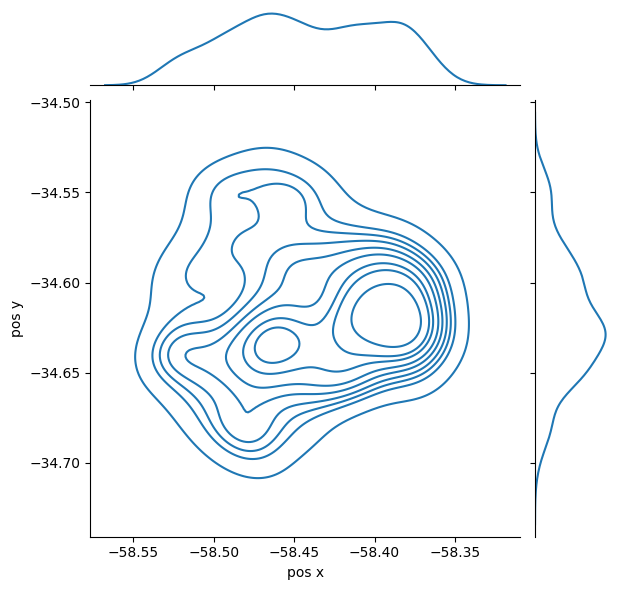

In [90]:
# Crea una matriz de densidad a partir de las coordenadas x e y
density = sns.jointplot(x="pos x", y="pos y", data=data, kind="kde")


c:\Users\Eduar\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1832: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



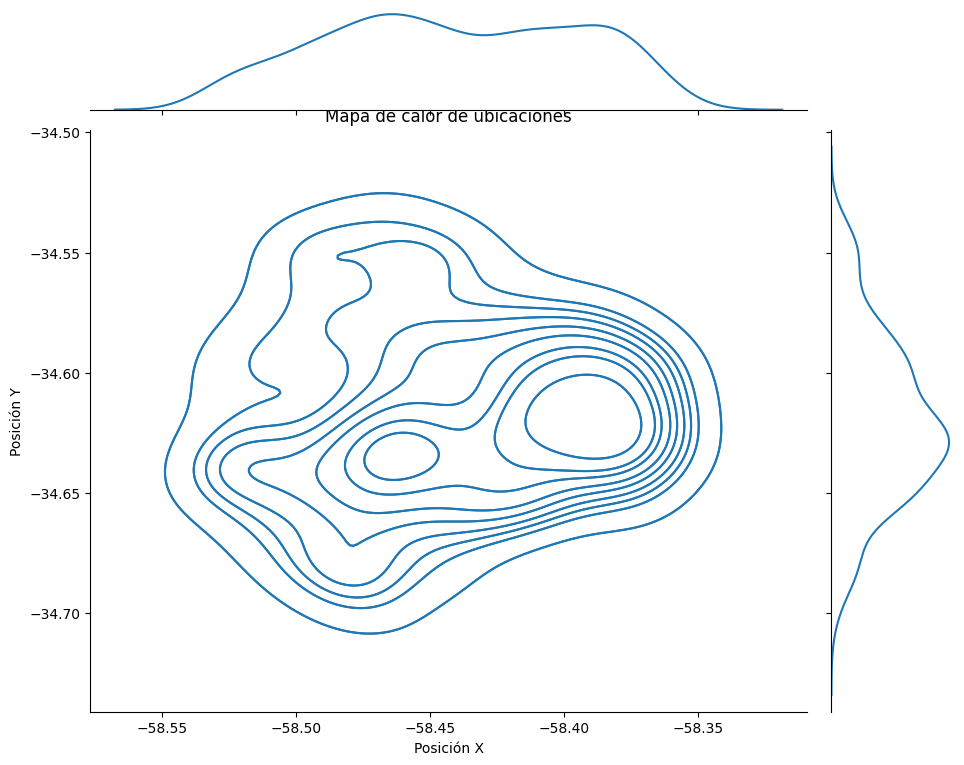

In [91]:
# Importa la función kdeplot
import seaborn as sns

# Crea el mapa de calor
density = sns.jointplot(x="pos x", y="pos y", data=data, kind="kde")

# Ajusta la paleta de colores
density.plot_joint(palette="rocket", func=sns.kdeplot)

# Agrega un título y etiquetas a los ejes
plt.title("Mapa de calor de ubicaciones")
plt.xlabel("Posición X")
plt.ylabel("Posición Y")

# Ajusta el tamaño del mapa
plt.gcf().set_size_inches(10, 8)

# Muestra el mapa de calor
plt.show()


In [103]:
data_nuevo = data[["pos x", "pos y", "HH", "VICTIMA"]]
data_nuevo

,pos x,pos y,HH,VICTIMA
0,-58.475340,-34.687570,4.0,MOTO
1,-58.508775,-34.669777,1.0,AUTO
2,-58.390403,-34.631894,7.0,MOTO
3,-58.465039,-34.680930,0.0,MOTO
4,-58.387183,-34.622466,5.0,MOTO
...,...,...,...,...
691,-58.433538,-34.645616,17.0,MOTO
692,-58.467398,-34.651178,1.0,MOTO
693,-58.472934,-34.619847,0.0,MOTO
694,-58.470668,-34.650217,10.0,AUTO


In [127]:
import pandas as pd

# Crear un diccionario para mapear cada valor único a su número correspondiente
mapeo = {
    'MOTO': 1,
    'AUTO': 2,
    'PEATON': 3,
    'SD': 4,
    'CARGAS': 5,
    'BICICLETA': 6,
    'PASAJEROS': 7,
    'MOVIL': 8,
    'OBJETO FIJO': 9,
    'PEATON_MOTO': 10
}

# Reemplazar los valores en la columna "VICTIMA" utilizando el diccionario de mapeo
data_nuevo['VICTIMA'] = data_nuevo['VICTIMA'].replace(mapeo)

# Verificar el DataFrame resultante
print(data_nuevo)


         pos x      pos y    HH  VICTIMA
0   -58.475340 -34.687570   4.0        1
1   -58.508775 -34.669777   1.0        2
2   -58.390403 -34.631894   7.0        1
3   -58.465039 -34.680930   0.0        1
4   -58.387183 -34.622466   5.0        1
..         ...        ...   ...      ...
691 -58.433538 -34.645616  17.0        1
692 -58.467398 -34.651178   1.0        1
693 -58.472934 -34.619847   0.0        1
694 -58.470668 -34.650217  10.0        2
695 -58.379762 -34.586796   6.0        6

[696 rows x 4 columns]


C:\Users\Eduar\AppData\Local\Temp\ipykernel_22044\3257588455.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [126]:
import pandas as pd

# Crear un diccionario para mapear cada valor único a su número correspondiente
mapeo = {
    'MOTO': 1,
    'AUTO': 2,
    'PEATON': 3,
    'SD': 4,
    'CARGAS': 5,
    'BICICLETA': 6,
    'PASAJEROS': 7,
    'MOVIL': 8,
    'OBJETO FIJO': 9,
    'PEATON_MOTO': 10
}

# Reemplazar los valores en la columna "VICTIMA" utilizando el diccionario de mapeo
data_nuevo['VICTIMA'] = data_nuevo['VICTIMA'].replace(mapeo)

# Verificar el DataFrame resultante
print(data_nuevo)


         pos x      pos y    HH  VICTIMA
0   -58.475340 -34.687570   4.0        1
1   -58.508775 -34.669777   1.0        2
2   -58.390403 -34.631894   7.0        1
3   -58.465039 -34.680930   0.0        1
4   -58.387183 -34.622466   5.0        1
..         ...        ...   ...      ...
691 -58.433538 -34.645616  17.0        1
692 -58.467398 -34.651178   1.0        1
693 -58.472934 -34.619847   0.0        1
694 -58.470668 -34.650217  10.0        2
695 -58.379762 -34.586796   6.0        6

[696 rows x 4 columns]


C:\Users\Eduar\AppData\Local\Temp\ipykernel_22044\3257588455.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [125]:
import pandas as pd

# Crear un diccionario para mapear cada valor único a su número correspondiente
mapeo = {
    'MOTO': 1,
    'AUTO': 2,
    'PEATON': 3,
    'SD': 4,
    'CARGAS': 5,
    'BICICLETA': 6,
    'PASAJEROS': 7,
    'MOVIL': 8,
    'OBJETO FIJO': 9,
    'PEATON_MOTO': 10
}

# Reemplazar los valores en la columna "VICTIMA" utilizando el diccionario de mapeo
data_nuevo['VICTIMA'] = data_nuevo['VICTIMA'].replace(mapeo)

# Verificar el DataFrame resultante
print(data_nuevo)


         pos x      pos y    HH  VICTIMA
0   -58.475340 -34.687570   4.0        1
1   -58.508775 -34.669777   1.0        2
2   -58.390403 -34.631894   7.0        1
3   -58.465039 -34.680930   0.0        1
4   -58.387183 -34.622466   5.0        1
..         ...        ...   ...      ...
691 -58.433538 -34.645616  17.0        1
692 -58.467398 -34.651178   1.0        1
693 -58.472934 -34.619847   0.0        1
694 -58.470668 -34.650217  10.0        2
695 -58.379762 -34.586796   6.0        6

[696 rows x 4 columns]


C:\Users\Eduar\AppData\Local\Temp\ipykernel_22044\3257588455.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
print(data_nuevo['VICTIMA'].unique())

[ 1  2  3  4  5  6  7  8  9 10]


In [110]:
data_nuevo.dtypes

pos x      float64
pos y      float64
HH         float64
VICTIMA      int64
dtype: object

In [111]:
x = data_nuevo["pos x"]
y = data_nuevo["pos y"]
z = data_nuevo["HH"]
victimas = data_nuevo["VICTIMA"]


In [112]:
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,

        opacity=0.8
    )
)])



In [65]:
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [113]:
victimas_unicas = data_nuevo["VICTIMA"].unique()

print(victimas_unicas)

[ 1  2  3  4  5  6  7  8  9 10]


In [136]:
def scatterplot_3d_victimas_plotly(data):
    # Definir colores para las víctimas
    colores = {
        1: "red",
        2: "green",
        3: "blue",
        4: "orange",
        5: "purple",
        6: "yellow",
        7: "black",
        8: "pink",
        9: "gray",
        10: "brown"
    }





    # Crear traza para el scatterplot
    trace = go.Scatter3d(
        x=[d["x"] for d in data],
        y=[d["y"] for d in data],
        z=[d["z"] for d in data],
        mode="markers",
        marker=dict(
            size=6,
            color=[colores[d["victima"]] for d in data],
            opacity=0.8
        )
    )

    # Crear layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(
                title="Posición X",
                range=[min(data, key=lambda x: x["x"])["x"], max(data, key=lambda x: x["x"])["x"]]
            ),
            yaxis=dict(
                title="Posición Y",
                range=[min(data, key=lambda x: x["y"])["y"], max(data, key=lambda x: x["y"])["y"]]
            ),
            zaxis=dict(
                title="Altura (HH)",
                range=[min(data, key=lambda x: x["z"])["z"], max(data, key=lambda x: x["z"])["z"]]
            )
        ),
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )


    # Figura
    fig = go.Figure(data=[trace], layout=layout)




    # Mostrar el gráfico
    plot(fig, show_link=False)

In [137]:
scatterplot_3d_victimas_plotly(data.copy())


TypeError: string indices must be integers, not 'str'

In [134]:
import plotly.graph_objects as go

def scatterplot_3d_victimas_plotly(data):
    # Definir colores para las víctimas
    colores = {
        1: "red",
        2: "green",
        3: "blue",
        4: "orange",
        5: "purple",
        6: "yellow",
        7: "black",
        8: "pink",
        9: "gray",
        10: "brown"
    }

    # Crear un diccionario para mapear números de víctimas a nombres
    nombres_victimas = {
        1: "Moto",
        2: "Auto",
        3: "Peatón",
        4: "SD",
        5: "Cargas",
        6: "Bicicleta",
        7: "Pasajeros",
        8: "Móvil",
        9: "Objeto fijo",
        10: "Peatón/Moto"
    }

    # Crear una lista para almacenar trazas
    trazas = []

    # Crear traza para cada categoría
    for victima, color in colores.items():
        filtered_data = [d for d in data if d["victima"] == victima]
        traza = go.Scatter3d(
            x=[d["x"] for d in filtered_data],
            y=[d["y"] for d in filtered_data],
            z=[d["z"] for d in filtered_data],
            mode="markers",
            name=nombres_victimas[victima],
            marker=dict(
                size=6,
                color=color,
                opacity=0.8
            )
        )
        trazas.append(traza)

    # Crear layout
    layout = go.Layout(
        scene=dict(
            xaxis=dict(
                title="Posición X",
                range=[min(data, key=lambda x: x["x"])["x"], max(data, key=lambda x: x["x"])["x"]]
            ),
            yaxis=dict(
                title="Posición Y",
                range=[min(data, key=lambda x: x["y"])["y"], max(data, key=lambda x: x["y"])["y"]]
            ),
            zaxis=dict(
                title="Altura (HH)",
                range=[min(data, key=lambda x: x["z"])["z"], max(data, key=lambda x: x["z"])["z"]]
            )
        ),
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )

    # Crear la figura
    fig = go.Figure(data=trazas, layout=layout)

    # Mostrar el gráfico con la leyenda
    fig.show()


In [133]:
import pandas as pd

# Crear un diccionario para mapear cada valor único a su número correspondiente
mapeo = {
    'MOTO': 1,
    'AUTO': 2,
    'PEATON': 3,
    'SD': 4,
    'CARGAS': 5,
    'BICICLETA': 6,
    'PASAJEROS': 7,
    'MOVIL': 8,
    'OBJETO FIJO': 9,
    'PEATON_MOTO': 10
}

# Reemplazar los valores en la columna "VICTIMA" utilizando el diccionario de mapeo
data_nuevo['VICTIMA'] = data_nuevo['VICTIMA'].replace(mapeo)

# Verificar el DataFrame resultante
print(data_nuevo)


         pos x      pos y    HH  VICTIMA
0   -58.475340 -34.687570   4.0        1
1   -58.508775 -34.669777   1.0        2
2   -58.390403 -34.631894   7.0        1
3   -58.465039 -34.680930   0.0        1
4   -58.387183 -34.622466   5.0        1
..         ...        ...   ...      ...
691 -58.433538 -34.645616  17.0        1
692 -58.467398 -34.651178   1.0        1
693 -58.472934 -34.619847   0.0        1
694 -58.470668 -34.650217  10.0        2
695 -58.379762 -34.586796   6.0        6

[696 rows x 4 columns]


C:\Users\Eduar\AppData\Local\Temp\ipykernel_22044\3257588455.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

